# Minnesota old-growth forests

This notebook shows how to do a couple of basic geopandas operations:
- Loading shapefiles
    - Cartographic boundaries of U.S. counties, filtered for Minnesota ([Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html))
    - Locations of U.S. Forest Service offices, filtered for Minnesota ([Forest Service](https://data-usfs.hub.arcgis.com/datasets/usfs::forest-service-office-locations-feature-layer/explore))
    - Stands of old-growth forests in Minnesota ([Minnesota Department of Natural Resources](https://gisdata.mn.gov/dataset/biota-dnr-forest-inv-old-growth))
- [Reprojecting](https://geopandas.org/en/stable/docs/user_guide/projections.html) from a geographic coordinate reference system to a projected CRS
- Counting up how many Forest Service offices in each Minnesota County, using a [spatial join](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html)
- Calculating the acreage of old-growth forest in Minnesota, broken down by county and tree species, using an [overlay](https://geopandas.org/en/stable/docs/user_guide/set_operations.html)

In [111]:
import geopandas as gpd

In [112]:
URL_COUNTIES = 'https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_county_20m.zip'
URL_FS_OFFICES = 'https://hub.arcgis.com/api/v3/datasets/6a2a912a2e0c4804a266c4d77fcaa953_0/downloads/data?format=shp&spatialRefId=4269&where=1%3D1'
URL_FORESTS = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_dnr_forest_inv_old_growth/shp_biota_dnr_forest_inv_old_growth.zip'

# https://epsg.io/26915
TARGET_CRS = 'EPSG:26915'

In [113]:
gdf_offices = gpd.read_file(URL_FS_OFFICES)

In [114]:
gdf_offices.head()

,OBJECTID,NAME,STREET,CITY,ZIP_CODE,STATE,PHONE,FAX_PHONE,MAILING_ST,MAILING_CI,...,LATITUDE,LONGITUDE,CONTACT,EQUIPMENT_,SEASONAL,WIRELESS_S,LOCATION_I,SYS_CREATE,SHAPE,geometry
0,347745,Lotek Wireless Inc.,115 Pony Dr,Newmarket,L3Y 7B5,ON,None,None,None,None,...,44.069930,-79.427751,None,false,false,false,0044fb861b76fd906de587fce54bcbcc,2023-11-30,None,POINT (-79.42775 44.06993)
1,347746,Sanyo North America Corporation Headquarters,2055 Sanyo Ave,San Diego,92154,CA,None,None,None,None,...,32.561352,-116.939063,None,false,false,false,0054ff861b76fd906de587fce54bcbf7,2023-11-30,None,POINT (-116.93906 32.56135)
2,347747,Apache-Sitgreaves National Forest and Springer...,30 S Chiricahua Dr,Springerville,85938,AZ,928-333-4301,928-333-5966,None,None,...,34.131600,-109.275117,None,false,false,true,44B3B1443524AB49B16B2EB6FEC895BE,2015-06-18,None,POINT (-109.27512 34.1316)
3,347748,College of Menominee Nation,N 172 State Hwy 47/55,Keshena,54135,WI,None,None,None,None,...,44.856843,-88.626604,None,false,false,false,4980F4781F3F9949A8E752AAB7BEDCA7,2018-12-10,None,POINT (-88.6266 44.85684)
4,347749,Crescent Ranger District,136471 Hwy 97 N,Crescent,97733,OR,541-433-3200,541-433-3224,None,None,...,43.474006,-121.907819,None,false,false,true,1FED4FFE8961654185EBF24BB198602D,2016-11-01,None,POINT (-121.90782 43.47401)


In [115]:
gdf_offices.columns

Index(['OBJECTID', 'NAME', 'STREET', 'CITY', 'ZIP_CODE', 'STATE', 'PHONE',
       'FAX_PHONE', 'MAILING_ST', 'MAILING_CI', 'MAILING_ZI', 'MAILING__1',
       'PHYSICAL_M', 'REGION', 'FOREST_NAM', 'DISTRICT_N', 'COUNTRY',
       'LATITUDE', 'LONGITUDE', 'CONTACT', 'EQUIPMENT_', 'SEASONAL',
       'WIRELESS_S', 'LOCATION_I', 'SYS_CREATE', 'SHAPE', 'geometry'],
      dtype='object')

In [116]:
gdf_offices.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [117]:
# filter for just minnesota offices
gdf_offices_mn = gdf_offices[gdf_offices.STATE == 'MN']

<Axes: >

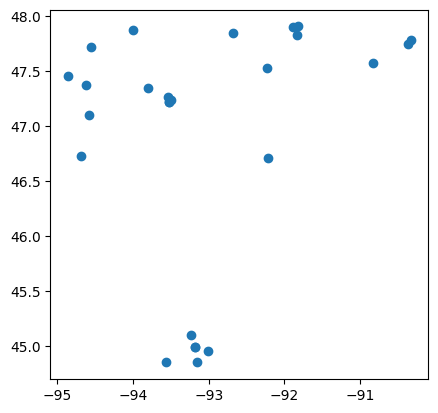

In [118]:
gdf_offices_mn.plot()

In [119]:
gdf_counties = gpd.read_file(URL_COUNTIES)

In [120]:
gdf_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,13,027,00345518,0500000US13027,13027,Brooks,Brooks County,GA,Georgia,06,1277341276,11955761,"POLYGON ((-83.73616 31.03768, -83.57396 31.033..."
1,31,095,00835869,0500000US31095,31095,Jefferson,Jefferson County,NE,Nebraska,06,1476765697,14202851,"POLYGON ((-97.36869 40.35039, -96.91606 40.349..."
2,51,683,01498430,0500000US51683,51683,Manassas,Manassas city,VA,Virginia,25,25493247,146287,"POLYGON ((-77.52666 38.7332, -77.49545 38.7706..."
3,56,021,01605075,0500000US56021,56021,Laramie,Laramie County,WY,Wyoming,06,6956355036,4348083,"POLYGON ((-105.27824 41.65666, -104.65334 41.6..."
4,13,135,01688166,0500000US13135,13135,Gwinnett,Gwinnett County,GA,Georgia,06,1116606767,15938345,"POLYGON ((-84.27117 33.9598, -84.26266 33.9871..."


In [121]:
gdf_counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOIDFQ', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER',
       'geometry'],
      dtype='object')

In [122]:
gdf_counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [123]:
# filter to just get MN counties
gdf_counties_mn = gdf_counties[gdf_counties.STUSPS == 'MN']

<Axes: >

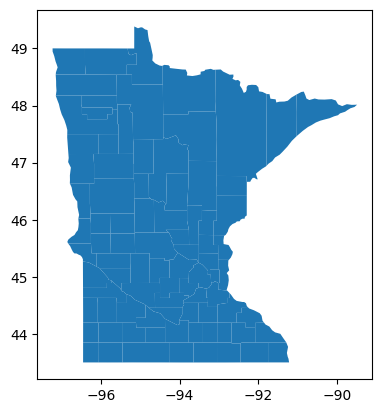

In [124]:
gdf_counties_mn.plot()

In [125]:
gdf_joined = gdf_counties_mn.sjoin(
    gdf_offices_mn,
    how='inner',
    predicate='contains'
)

In [126]:
gdf_joined.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME_left,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,COUNTRY,LATITUDE,LONGITUDE,CONTACT,EQUIPMENT_,SEASONAL,WIRELESS_S,LOCATION_I,SYS_CREATE,SHAPE
492,27,019,00659455,0500000US27019,27019,Carver,Carver County,MN,Minnesota,06,...,None,44.855354,-93.558796,None,false,false,false,4454ff861b76fd906de587fce54bcbf5,2023-11-30,None
739,27,021,00659456,0500000US27021,27021,Cass,Cass County,MN,Minnesota,06,...,USA,46.729553,-94.685900,None,false,false,false,B799305D07E1C848A0981B2EF5E34E46,2018-01-19,None
739,27,021,00659456,0500000US27021,27021,Cass,Cass County,MN,Minnesota,06,...,USA,47.099802,-94.572597,None,false,false,true,A56C5C8976663444B37AD43ED6D5807B,2017-12-14,None
739,27,021,00659456,0500000US27021,27021,Cass,Cass County,MN,Minnesota,06,...,USA,47.379240,-94.614316,None,false,false,true,4860FD3B563387478354336695DEF894,2016-10-19,None
841,27,061,00659476,0500000US27061,27061,Itasca,Itasca County,MN,Minnesota,06,...,USA,47.218074,-93.521121,None,false,false,false,0BD0B9DF222CDE4C9D065ADBB749DB78,2018-12-10,None


In [127]:
len(gdf_joined)

26

In [128]:
# count up offices by county
gdf_joined.groupby('NAMELSAD').size().reset_index(name='count').sort_values('count', ascending=False)

,NAMELSAD,count
9,St. Louis County,6
6,Itasca County,5
8,Ramsey County,3
4,Cook County,3
3,Cass County,3
1,Beltrami County,2
0,Anoka County,1
2,Carver County,1
5,Dakota County,1
7,Koochiching County,1


## Overlay

Calculate the percentage of old-growth forest in each county, broken down by species, using an [overlay](https://geopandas.org/en/stable/docs/user_guide/set_operations.html).

In [129]:
gdf_forests = gpd.read_file(
    URL_FORESTS,
    layer='dnr_forest_inventory_old_growth'
)

In [130]:
gdf_forests.head()

,AREA_RAN,COUNTY_NUM,LOCATION,LABEL,GIS_ACRES,PLS,LAST_INVEN,STAND_KEY,COVER_TP_I,STAND_AGE_,MAIN_SP_ID,MAIN_SP_DE,SITE_INDEX,OLDGROWTH_,OLDGROWTHI,OG_COMMENT,STAND_AGE1,SHAPE_Leng,SHAPE_Area,geometry
0,232,1,t04926w1084194,84194 NH53,35.6,t04926w10,2004/02/18,384194,20,104,23,Basswood,51.0,Designated Old Growth,OG5-41,None,125,1995.821394,144236.089457,"POLYGON ((452769.697 5177563.754, 452757.682 5..."
1,232,1,t04926w1384307,84307 LH56,25.8,t04926w13,1981/01/01,384307,9,112,2,"Elm, American",49.0,Designated Old Growth,OG5-42,None,156,1496.057546,104480.546155,"POLYGON ((455670.072 5175296.053, 455674.374 5..."
2,232,1,t04927w3684468,84468 NH58,43.2,t04927w36,2019/05/09,384468,20,75,23,Basswood,55.0,Designated Old Growth,OG5-43,None,80,2257.470370,175014.296483,"POLYGON ((445522.938 5171687.457, 445522.501 5..."
3,232,1,t04926w3484500,84500 C45,35.7,t04926w34,1996/01/01,384500,73,134,73,"Cedar, White",36.0,Candidate Old Growth,LCOG1A,None,163,2719.166632,144364.672177,"POLYGON ((452693.765 5171455.139, 452698.649 5..."
4,232,1,t04927w3684509,84509 NP58,34.7,t04927w36,2019/05/09,384509,52,85,52,"Pine, Norway (Red)",56.0,Candidate Old Growth,SLM-RP-4,None,90,2181.325524,140323.850742,"POLYGON ((446102.438 5171387.196, 446102.679 5..."


<Axes: >

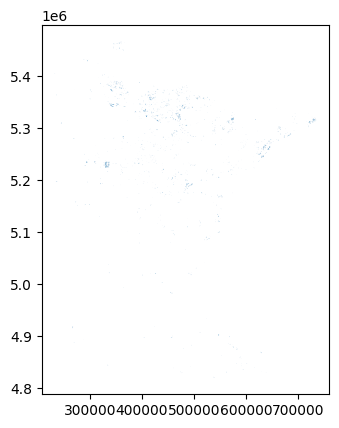

In [131]:
gdf_forests.plot()

In [133]:
gdf_forests.crs == gdf_counties_mn.crs

False

In [134]:
# reproject
gdf_forests = gdf_forests.to_crs(TARGET_CRS)
gdf_counties_mn = gdf_counties_mn.to_crs(TARGET_CRS)

In [135]:
gdf_forests.crs == gdf_counties_mn.crs

True

In [136]:
gdf_forests_joined = gpd.overlay(
    gdf_counties_mn,
    gdf_forests,
    how='union'
)

In [137]:
gdf_forests.area

0       144236.089457
1       104480.546155
2       175014.296483
3       144364.672177
4       140323.850742
            ...      
2986    135051.335922
2987    199791.018193
2988    107455.488787
2989    102247.835865
2990     21970.935933
Length: 2991, dtype: float64

In [138]:
# calculate the area of old-growth forest by county
# https://gis.stackexchange.com/a/421920
gdf_forests_joined['area_joined'] = gdf_forests_joined.area
gdf_forests_joined['old_growth_area_by_county'] = gdf_forests_joined['area_joined'] / gdf_forests_joined['GIS_ACRES']

In [139]:
gdf_forests_joined.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,SITE_INDEX,OLDGROWTH_,OLDGROWTHI,OG_COMMENT,STAND_AGE1,SHAPE_Leng,SHAPE_Area,geometry,area_joined,old_growth_area_by_county
0,27,065,00659478,0500000US27065,27065,Kanabec,Kanabec County,MN,Minnesota,06,...,63.0,Designated Old Growth,EH-205B,None,82.0,5499.403958,526707.527282,"POLYGON ((487112.394 5109580.485, 487137.398 5...",526707.527282,4045.372713
1,27,065,00659478,0500000US27065,27065,Kanabec,Kanabec County,MN,Minnesota,06,...,56.0,Designated Old Growth,KA164c,None,108.0,905.882387,50982.810848,"POLYGON ((483454.644 5066040.727, 483453.332 5...",50982.810848,4046.254829
2,27,065,00659478,0500000US27065,27065,Kanabec,Kanabec County,MN,Minnesota,06,...,56.0,Designated Old Growth,KA164b,None,110.0,1617.584256,100550.032777,"POLYGON ((483741.222 5064683.849, 483695.942 5...",100550.032777,4054.436806
3,27,097,00659494,0500000US27097,27097,Morrison,Morrison County,MN,Minnesota,06,...,48.0,Designated Old Growth,HH-ASH-3,None,100.0,941.068888,33966.861962,"POLYGON ((372611.63 5099806.77, 372622.331 509...",33966.861962,4043.674043
4,27,097,00659494,0500000US27097,27097,Morrison,Morrison County,MN,Minnesota,06,...,45.0,Designated Old Growth,ASP-WP-07,None,118.0,4867.437517,210983.016415,"POLYGON ((395127.428 5078654.802, 395128.893 5...",210983.016415,4049.578050


In [140]:
# group by county name and tree species
gdf_forests_joined.groupby(['NAME','MAIN_SP_DE']).agg({'old_growth_area_by_county':'sum'})

old_growth_area_by_county
NAME   MAIN_SP_DE                                  
Aitkin Ash, Black                      72750.723026
       Basswood                        12174.797603
       Cedar, White                    76936.752998
       Elm, American                    4049.633572
       Maple, Red                       4047.090745
...                                             ...
Winona Oak, Northern Red               40460.038289
       Oak, White                       4059.084668
       Pine, White                      4052.460073
Wright Oak, Northern Red               36408.351155
       Oak, White                       4042.558789

[250 rows x 1 columns]